In [3]:
import ROOT
import copy
import matplotlib.pyplot as plt
import numpy as np

In [4]:
input_file = "outroot/nSidis_005036.root"
tfile = ROOT.TFile(input_file)
tree = tfile.Get("diphoton")

In [5]:
def get_fit_counts_purity(hist):
    fit = ROOT.TF1("fit","gaus(0)+pol2(3)",0.08,0.23)
    HIST = copy.deepcopy(hist)
    scale=HIST.GetEntries()
    HIST.Scale(1/HIST.GetEntries())
    fit.SetParameters(0.5,0.135,0.002,1,1,1)
    fit.SetParLimits(0,0.01,1)
    fit.SetParLimits(1,0.129,0.14)
    fit.SetParLimits(2,0.005,0.02)
    HIST.Fit(fit,"QNR0")
    
    # Get the parameters of the Gaussian component
    mean = fit.GetParameter(1)
    sigma = fit.GetParameter(2)
    amplitude = fit.GetParameter(0)
    
    # Get all pars
    pars = [fit.GetParameter(i) for i in range(6)]
    err_pars = [fit.GetParError(i) for i in range(6)]
        
    # Create a TF1 object for the Gaussian component
    xmin,xmax=0.106,0.164
    gaus_func = ROOT.TF1("gaus_func", "gaus", xmin,xmax)
    gaus_func.SetParameters(amplitude, mean, sigma)

    # Get the parameters of the polynomial component
    pol2_params = [fit.GetParameter(i) for i in range(3, 6)]

    # Create a TF1 object for the polynomial component
    pol2_func = ROOT.TF1("pol2_func", "pol2", xmin,xmax)
    [pol2_func.SetParameter(i,pol2_params[i]) for i in range(len(pol2_params))]
    
    gaus_int = gaus_func.Integral(mean-2*sigma,mean+2*sigma)
    pol_int = pol2_func.Integral(mean-2*sigma,mean+2*sigma)

    purity = (gaus_int)/(gaus_int+pol_int)
    
    # Get the bin numbers corresponding to purity edges
    bin_low = hist.FindBin(mean-2*sigma)
    bin_high = hist.FindBin(mean+2*sigma)
    # Calculate the integral of the histogram between these bins
    integral = hist.Integral(bin_low, bin_high)
    # Rescale fit params
    
    for ipar in [0,3,4,5]:
        fit.SetParameter(ipar,fit.GetParameter(ipar)*scale)
    fit.SetNpx(1000000)
    if(purity<0.01): # Return -1 because the fit may have failed
        return -1,-1,-1
    else:
        return copy.deepcopy(fit),purity*integral,purity,pars,err_pars

Purity (mean +/- 2*sigma)
  No cuts --> 0.4793102184386645
  Egamma>0.6 --> 0.7915418341477938
  Classifier p>0.9 cuts --> 0.7426021976131763


Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


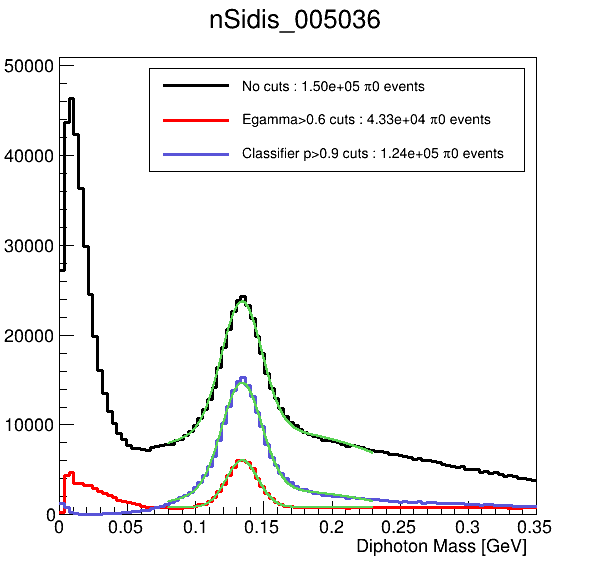

In [6]:
canvas = ROOT.TCanvas("c","c",600,600)
p_thresh = 0.9

title = input_file.split("/")[-1].replace(".root","")
hist_min,hist_max=0,0.35
h1 = ROOT.TH1F("h1",title+";Diphoton Mass [GeV];Counts",100,hist_min,hist_max)
h2 = ROOT.TH1F("h2",title+";Diphoton Mass [GeV];Counts",100,hist_min,hist_max)
h3 = ROOT.TH1F("h3",title+";Diphoton Mass [GeV];Counts",100,hist_min,hist_max)

h1.SetLineColor(1); h2.SetLineColor(2); h3.SetLineColor(9);
h1.SetLineWidth(3); h2.SetLineWidth(3); h3.SetLineWidth(3);

tree.Draw("M_gg>>h1","","hist")
tree.Draw("M_gg>>h2","E_gamma_1>0.6 && E_gamma_2>0.6","hist same")
tree.Draw("M_gg>>h3","p_gamma_1>{}&&p_gamma_2>{}".format(p_thresh,p_thresh),"hist same")

h1.GetYaxis().SetRangeUser(0,h1.GetMaximum()*1.1)
ROOT.gStyle.SetOptStat(0)
legend=ROOT.TLegend(0.25,0.7,0.88,0.88)
f1,N1,u1,_,_=get_fit_counts_purity(h1); f1.SetLineColor(8); f1.SetLineStyle(9);
f2,N2,u2,_,_=get_fit_counts_purity(h2); f2.SetLineColor(8); f2.SetLineStyle(9);
f3,N3,u3,_,_=get_fit_counts_purity(h3); f3.SetLineColor(8); f3.SetLineStyle(9);

f1.Draw("l same")
f2.Draw("l same")
f3.Draw("l same")

legend.AddEntry(h1,"No cuts : {:.2e} #pi0 events".format(int(N1)),"l")
legend.AddEntry(h2,"Egamma>0.6 cuts : {:.2e} #pi0 events".format(int(N2)),"l")
legend.AddEntry(h3,"Classifier p>{} cuts : {:.2e} #pi0 events".format(p_thresh,int(N3)),"l")
legend.Draw()
canvas.Draw()

print("Purity (mean +/- 2*sigma)")
print("  No cuts -->",u1)
print("  Egamma>0.6 -->",u2)
print("  Classifier p>{} cuts -->".format(p_thresh),u3)

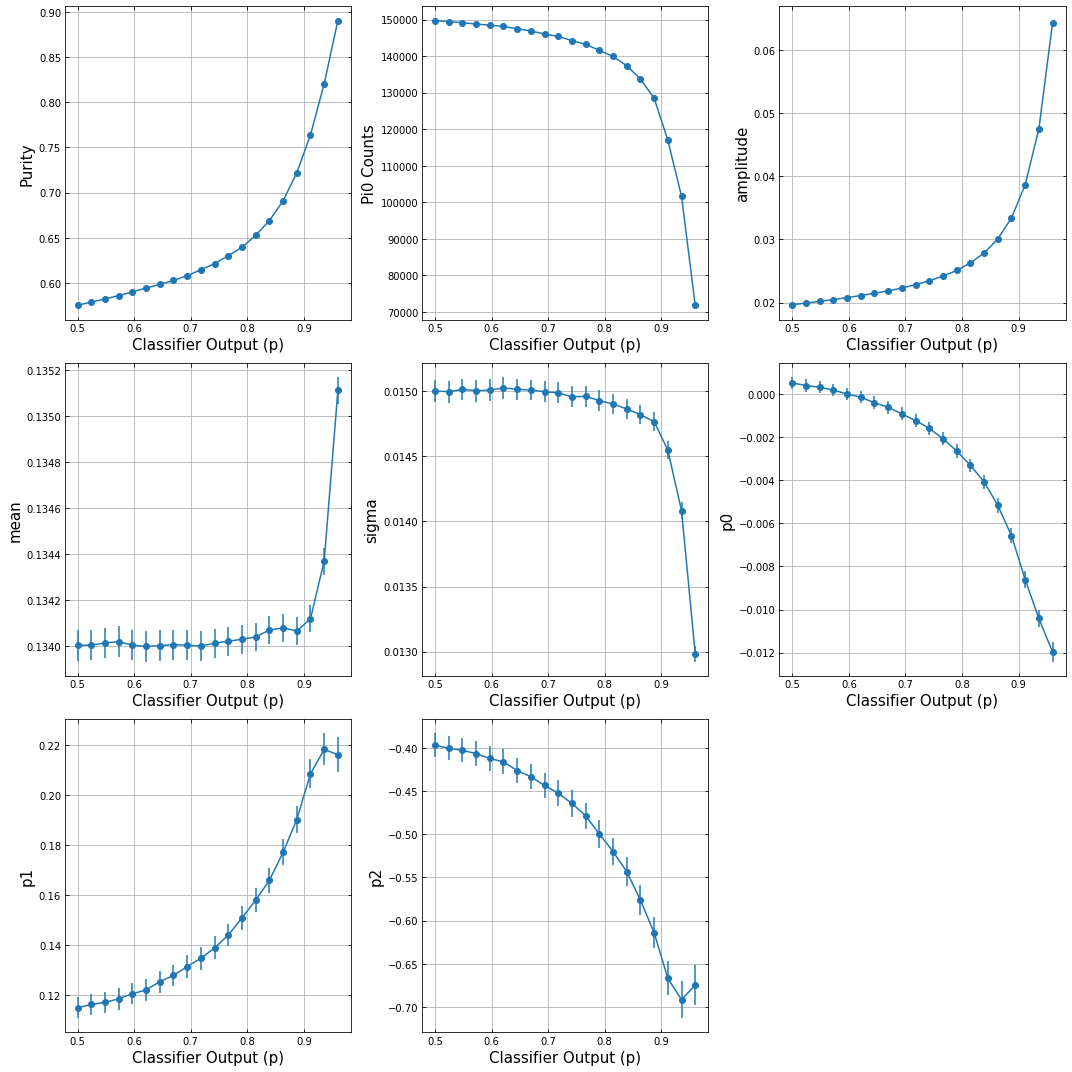

Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter

In [9]:
# Define the range of p_thresh values to loop over
p_thresh_vals = np.linspace(0.5, 0.96, 20)

# Define the histogram range and binning
hist_min, hist_max = 0, 0.35
nbins = 100

# Create arrays to store the results
purities = []
counts = []
fit_pars = [[] for i in range(6)]
fit_par_errs = [[] for i in range(6)]

# Loop over p_thresh values and fill the histogram for each value
for p_thresh in p_thresh_vals:
    h = ROOT.TH1F("h", ";Diphoton Mass [GeV];Counts", nbins, hist_min, hist_max)
    tree.Draw("M_gg>>h", "p_gamma_1 > {} && p_gamma_2 > {}".format(p_thresh, p_thresh), "hist same")
    
    # Call the fit function and store the results
    fit, count, purity, pars, err_pars = get_fit_counts_purity(h)
    if purity != -1:
        purities.append(purity)
        counts.append(count)
        for i in range(6):
            fit_pars[i].append(pars[i])
            fit_par_errs[i].append(err_pars[i])

# Convert the lists to arrays for easier plotting
purities = np.array(purities)
counts = np.array(counts)
fit_pars = np.array(fit_pars)
fit_par_errs = np.array(fit_par_errs)

# Create the plots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
# Plot the purity as a function of p_thresh
axs[0].plot(p_thresh_vals, purities, marker='o')
axs[0].set_xlabel('Classifier Output (p)',fontsize=15)
axs[0].set_ylabel('Purity',fontsize=15)

# Plot the counts as a function of p_thresh
axs[1].plot(p_thresh_vals, counts, marker='o')
axs[1].set_xlabel('Classifier Output (p)',fontsize=15)
axs[1].set_ylabel('Pi0 Counts',fontsize=15)

# Plot the fit parameters as a function of p_thresh
fit_param_names = ['amplitude', 'mean', 'sigma', 'p0', 'p1', 'p2']
for i in range(6):
    axs[i+2].errorbar(p_thresh_vals, fit_pars[i], yerr=fit_par_errs[i], marker='o')
    axs[i+2].set_xlabel('Classifier Output (p)',fontsize=15)
    axs[i+2].set_ylabel(fit_param_names[i],fontsize=15)

# Set tick parameters and grid for all subplots
for ax in axs:
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.grid(True)

# Delete the ninth plot since nothing is plotted there
fig.delaxes(axs[-1])

# Adjust spacing between subplots and show the plot
fig.tight_layout()
plt.show()